In [2]:
import hdf5storage
from helpers import *
from get_data import *
from synchrony import *
import numpy as np


%load_ext autoreload
%autoreload 2


### Loading in the bat data (LFP and positional data)
#### We first need to load in the LFP data, which in this case is stored in a MATLAB file. We can do this using ```hdf5storage```. The bat's positional data is stored in a matlab file (not accessible for public use), but luckily the accessors for this data can be found in ```dataset.py``` thanks to the Yartsev Lab.

In [3]:
data_path = './data'
bat_id = '32622'
date = '231007'
lfp_file_path = './data/ephys/32622_231007_lfp.mat'


#Clean up position data (remove NaNs, etc.) and load in LFP from given file path
lfp_mat, cleaned_pos, session = load_and_clean_bat_data(data_path, bat_id, date, lfp_file_path,use_cache=True)

Structure of lfp_data: <class 'numpy.ndarray'>, (1, 2)
Loading Flight Room | 32622 | 231007 from cache...
Positional data shape: (841160, 3)
Cleaned positional data shape: (841160, 3)


### Time synchronization
#### Before we get to the main attraction (the LFP data), we need to ensure our data is synchronized. To do this, we need to extract global timestamps from both the LFP and positional data and make sure they start at the same time.

In [4]:
lfp_timestamps_edges, binned_pos, pos_timestamps, lfp_indices, pos_mask = sync_and_bin_data(lfp_mat, session,cleaned_pos)

#lfp_timestamp_edges stores edges between timebins. this will be useful for aligning the LFP data with the position data
#binned_pos is the cleaned position averaged over the timebins
#pos_mask is a boolean array that marks the non-negative position timestamps
#pos_timestamps is the cleaned and filtered timestamps of the position data
#lfp_indices is a boolean array that marks the non-negative, decimated LFP timestamps


LFP timestamps structure: (17222917, 1)
Decimated LFP timestamps shape: (172230,)
LFP timestamp edges shape: (170691,)
Positional timestamp diff (microseconds): [8333.33333331 8333.33333334 8333.33333334 ... 8333.33772278 8333.33771515
 8333.33771515]
Cleaned positional data shape: (824435, 3)
Binned positional data shape: (170690, 3)


In [ ]:
print("Number of NaN values in binned_pos:", np.isnan(binned_pos).sum())


#### Inside of ```lfp_timestamps_edges```, we store the *edges* between timebins. We will use this to later to bin the position data; instead of downsampling the data like we did the LFP, we will average across bins (between two edges) of the LFP timebins to get synchronized data streams.

In [ ]:
print("First few elements of binned_pos:\n", binned_pos[:, :5]) # NaN values at beginning and end are expected; position is not recorded when bat is not visible.

print("First few LFP bins:", lfp_timestamps_edges[:5])

##### Notice above that the LFP timestamp edges have N+1 the shape of the binned position. This makes sense and is expected; `lfp_timestamps_edges` contains the bins (which are stored in groups of two, i.e. the first bin is [0, 4514.4426] and so on) for which the position was binned into.

# Ben splits cluster 3

w/ pre processing

-take median of all x, add buffer (3% buffer)
-cluster all the position information 
-apply masks afterward

-get big data structure for raw data (later)
    -position, lfp, timestamp (synced) 

In [95]:
lfp_bat_combined = extract_and_downsample_lfp_data(lfp_mat) #uses scipy decimate to downsample LFP
LFPs = filter_data(lfp_bat_combined, 1, fs=25, filt_type='high', use_hilbert=True) 
LFPs = LFPs[lfp_indices] # mask for non-negativity 

Loading cached LFP data...
LFP combined shape: (172230, 384)


In [119]:
# Extract all flights in the third cluster
flights_cluster = session.get_flights_by_cluster((2,))

# Extract all x-values from the flights
x_values = np.concatenate([flight.filtered_position[:, 0] for flight in flights_cluster])
x_values = x_values[~np.isnan(x_values)]

# Calculate the minimum and maximum x-values
min_x_value = np.min(x_values)
max_x_value = np.max(x_values)

# Calculate the median of the x-values
median_x_value = np.median(x_values)

# Calculate the 3% buffer based on the range of x-values
x_range = max_x_value - min_x_value
buffer = 0.03 * x_range

# Define the range with the buffer around the median
lower_bound = median_x_value - buffer
upper_bound = median_x_value + buffer

print(f"Median x-value position: {median_x_value}")
print(f"Buffer range: ({lower_bound}, {upper_bound})")
# Extract all y-values from the flights
y_values = np.concatenate([flight.filtered_position[:, 1] for flight in flights_cluster])
y_values = y_values[~np.isnan(y_values)]

# Calculate the minimum and maximum y-values
min_y_value = np.min(y_values)
max_y_value = np.max(y_values)

# Calculate the median of the y-values
median_y_value = np.median(y_values)

# Calculate the 3% buffer based on the range of y-values
y_range = max_y_value - min_y_value
buffer_y = 0.03 * y_range

# Define the range with the buffer around the median
lower_bound_y = median_y_value - buffer_y
upper_bound_y = median_y_value + buffer_y

print(f"Median y-value position: {median_y_value}")
print(f"Buffer range: ({lower_bound_y}, {upper_bound_y})")

Median x-value position: 0.6406340942382812
Buffer range: (0.48845591186523435, 0.7928122766113281)
Median y-value position: 0.8960263671875
Buffer range: (0.8311299002431647, 0.9609228341318352)


In [120]:
def left_or_right(x, lower,upper):
    # Classify the input x values
    return np.where(
        x < lower, "left",  # Values less than the lower buffer are "left"
        np.where(x > upper, "right", "within buffer")  # Values greater than the upper buffer are "right"
    )

##### getting the binned position to match corresponding flights:
flight_count =0
flight_data = []

for flight in session.get_flights_by_cluster([2]): #marking cluster 3 flights
    flight_count +=1
    flight_bool, _, _ = get_flight_boolean_array(session,flight_count)

    # Apply pos_mask (formerly valid_indices) to the flight boolean array and phase labels
    labels = flight_bool[pos_mask]
     # Label timebins for this flight
    timebin_labels = label_timebins(lfp_timestamps_edges, labels, pos_timestamps, is_discrete=True)
    
    flight_lfp = LFPs[timebin_labels > 0] # mark LFP points which mask to specific flight in cluste

     # Get binned position data for this flight
    flight_pos = binned_pos[timebin_labels > 0]
    
####### Current analysis task: marking whether current x is less than or greater than x=0
    flight_data.append(np.column_stack((
        np.full(len(flight_pos), flight_count),
        left_or_right(flight_pos[:,1], lower_bound_y, upper_bound_y),
        flight_lfp
    )))
    


In [121]:
flight_data = np.vstack(flight_data)

In [122]:
flight_data

array([['1', 'left', '(-500.3070232076409+647.6989627071845j)', ...,
        '(415.006904207959+148.09051811485455j)',
        '(469.483962057222+75.63714421360864j)',
        '(533.3019179642059+156.0862412852906j)'],
       ['1', 'left', '(-1542.710432132904-420.2947701574179j)', ...,
        '(559.167079163158+1037.6565609308038j)',
        '(534.384857429464+923.5437032871795j)',
        '(577.6366705379136+1090.6505650047293j)'],
       ['1', 'left', '(-92.09675825681015-1631.16107837899j)', ...,
        '(-1039.0004053648206+505.4811876592816j)',
        '(-821.8673277065101+426.6095645387969j)',
        '(-983.3169612866612+542.5894995690015j)'],
       ...,
       ['34', 'within buffer', '(1386.162516438894+329.961920951532j)',
        ..., '(-59.47863205368271+825.7154359575413j)',
        '(10.452330779130175+697.815306208259j)',
        '(-31.33403557399094+765.8242961234596j)'],
       ['34', 'within buffer', '(492.4793076336379+1110.5098818262322j)',
        ..., '(-932.08

## training TIMBRE

In [123]:
label_mapping = {"left": 0, "right": 1}
classifications = flight_data[:,1]
# Assuming flight_data[:, 2] is a 2D array of strings
# Convert all elements to complex numbers while preserving the original shape
lfp_data = np.array([np.array([complex(val) for val in row]) for row in flight_data[:, 2:]])

# Map the labels to integers
Y = np.array([label_mapping[label] for label in classifications if label != "within buffer"])  # Exclude buffer range

# Extract the LFP data corresponding to non-"0" labels
X = lfp_data[classifications != "within buffer"]  # Use rows where the labels aren't "0"

In [124]:
X

array([[ -500.30702321 +647.69896271j,  -515.55987709 +594.83693525j,
         -498.21230683 +620.02329926j, ...,
          415.00690421 +148.09051811j,   469.48396206  +75.63714421j,
          533.30191796 +156.08624129j],
       [-1542.71043213 -420.29477016j, -1468.80179748 -495.35005044j,
        -1517.40698076 -513.05886221j, ...,
          559.16707916+1037.65656093j,   534.38485743 +923.54370329j,
          577.63667054+1090.650565j  ],
       [  -92.09675826-1631.16107838j,    -6.13454657-1620.49929245j,
           22.03873897-1663.72545517j, ...,
        -1039.00040536 +505.48118766j,  -821.86732771 +426.60956454j,
         -983.31696129 +542.58949957j],
       ...,
       [-1247.01215044-1136.23868535j, -1250.1480422 -1142.89961725j,
        -1312.62880084-1125.37471711j, ...,
          -58.73512593 +822.41350803j,   -64.93498373 +702.21278198j,
         -158.46272026 +774.10820378j],
       [ -144.9623108  +661.73596176j,   -93.29647483 +732.53619488j,
          -62.03987801

In [125]:
# distribution of categorical labels
unique, counts = np.unique(Y, return_counts=True)
total = len(Y)
distribution = {label: (count / total) * 100 for label, count in zip(unique, counts)}
print(distribution)

{0: 50.016989466530745, 1: 49.98301053346925}


In [126]:
Y.shape, X.shape

((2943,), (2943, 384))

In [137]:
from sklearn.model_selection import KFold

k = 3 # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Assuming X and Y are your data and labels
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Fold {fold + 1}")
    print(f"Train indices: {train_index}")
    print(f"Test indices: {test_index}")

    # Use train_index and test_index to index into X and Y
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    # Call TIMBRE or other model with the current fold's train-test split
    model, fitted_model, test_acc = TIMBRE(
        X=X,
        Y=Y,
        inds_test=test_index,
        inds_train=train_index,
        hidden_nodes=hidden_nodes,
        learn_rate=learn_rate,
        is_categorical=is_categorical,
        verbosity=0
    )

    print(f"Fold {fold + 1} Test Accuracy: {test_acc}")

Fold 1
Train indices: [   0    1    2 ... 2937 2938 2940]
Test indices: [  12   18   25   29   30   32   43   44   45   48   49   51   52   56
   57   59   63   67   69   70   73   76   80   84   87   88   93   96
  100  102  104  108  109  111  120  123  124  134  135  139  141  149
  152  157  162  163  166  168  170  173  175  177  178  179  183  184
  188  194  196  199  203  208  210  211  212  218  219  220  221  226
  229  231  233  237  238  239  240  246  247  251  252  254  256  257
  259  261  263  266  270  272  276  278  279  282  283  289  290  291
  296  297  298  299  303  309  313  314  315  318  321  322  324  325
  331  332  342  343  347  349  350  353  354  358  360  361  365  366
  367  368  381  387  393  402  406  407  408  410  411  414  415  416
  420  422  423  424  430  432  433  435  436  438  439  440  443  445
  449  450  456  457  460  461  462  463  464  471  472  478  479  480
  482  485  486  495  497  498  506  507  508  509  511  518  521  522
  527

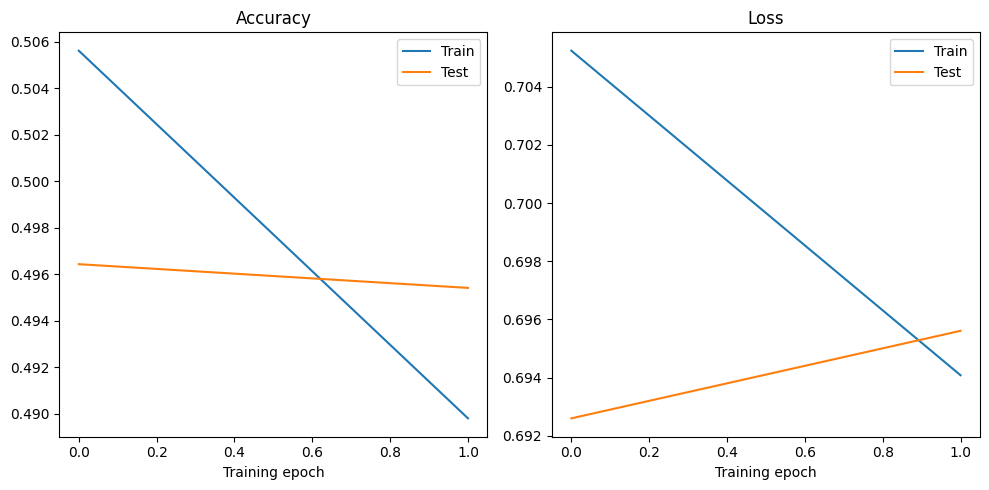

In [138]:
from matplotlib import pyplot as plt

# Plot accuracy and loss from fittedModel
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot training vs. validation accuracy
axs[0].plot(fitted_model.history['accuracy'], label='Train')
axs[0].plot(fitted_model.history['val_accuracy'], label='Test')
axs[0].set_title('Accuracy')
axs[0].set_xlabel('Training epoch')
axs[0].legend()

# Plot training vs. validation loss
axs[1].plot(fitted_model.history['loss'], label='Train')
axs[1].plot(fitted_model.history['val_loss'], label='Test')
axs[1].set_title('Loss')
axs[1].set_xlabel('Training epoch')
axs[1].legend()

plt.tight_layout()
plt.show()


Testing hidden_nodes=3, iteration=1
Test Accuracy: 0.5415959358215332


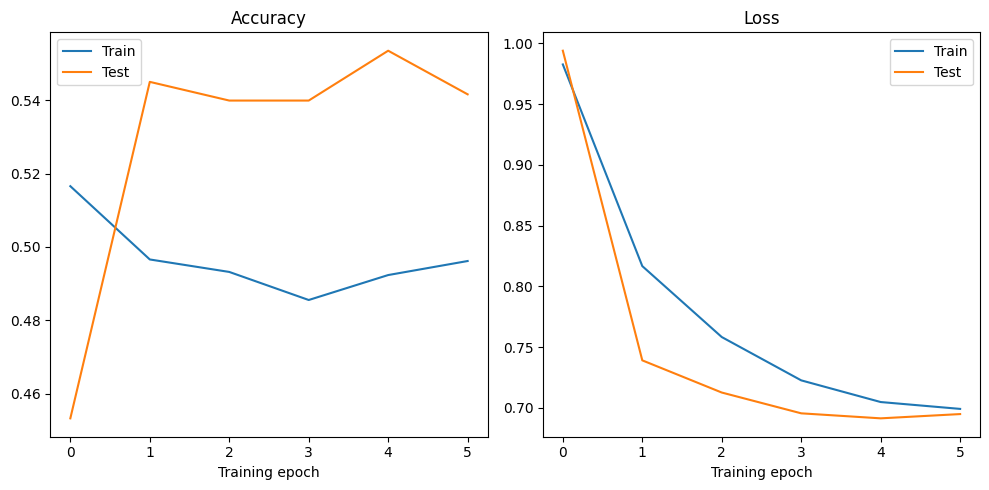

Testing hidden_nodes=3, iteration=2
Test Accuracy: 0.5432937145233154


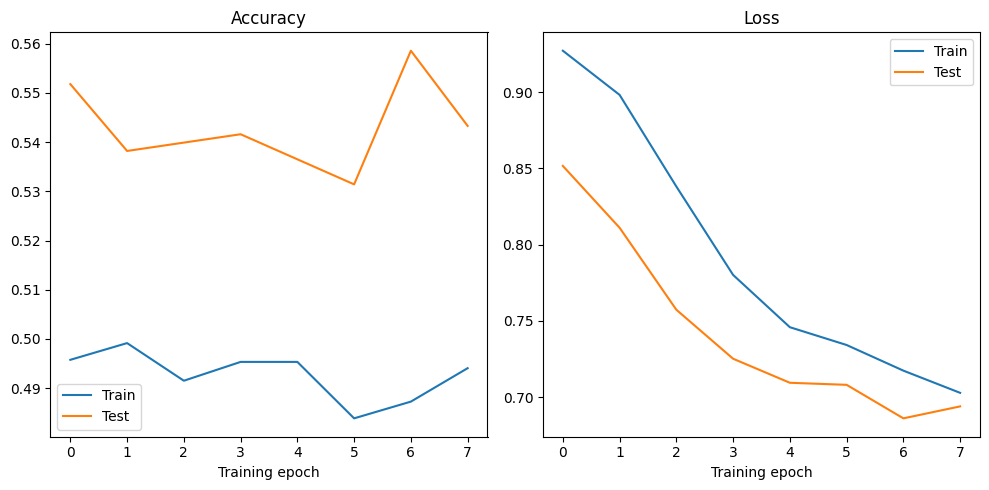

Testing hidden_nodes=3, iteration=3
Test Accuracy: 0.4651952385902405


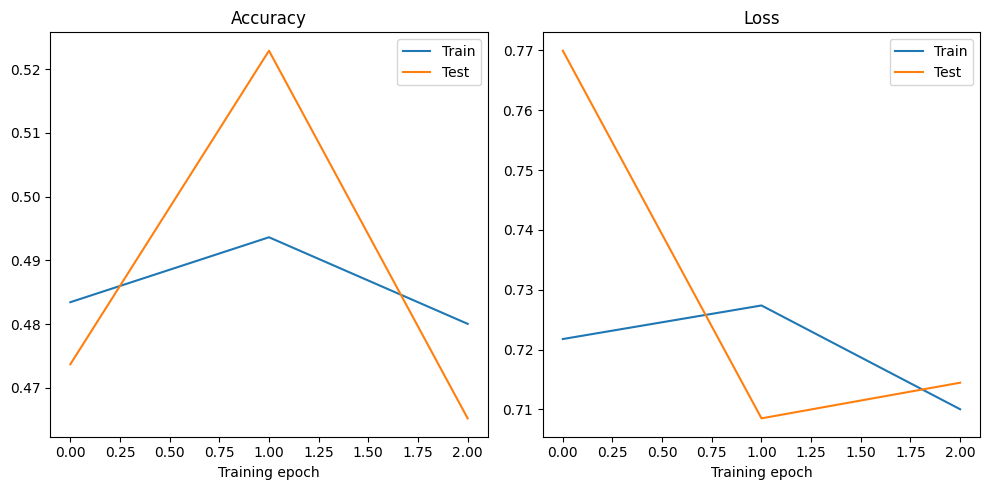

Testing hidden_nodes=10, iteration=1
Test Accuracy: 0.5432937145233154


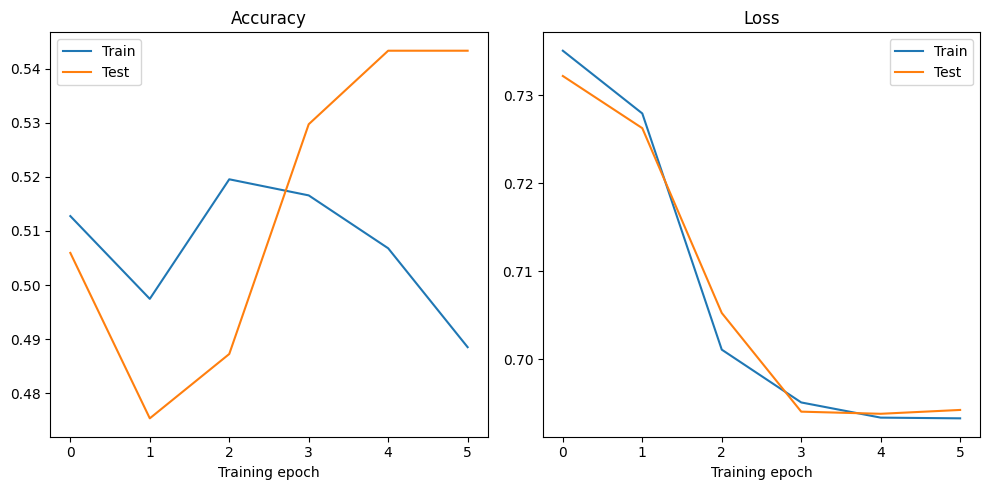

Testing hidden_nodes=10, iteration=2
Test Accuracy: 0.5432937145233154


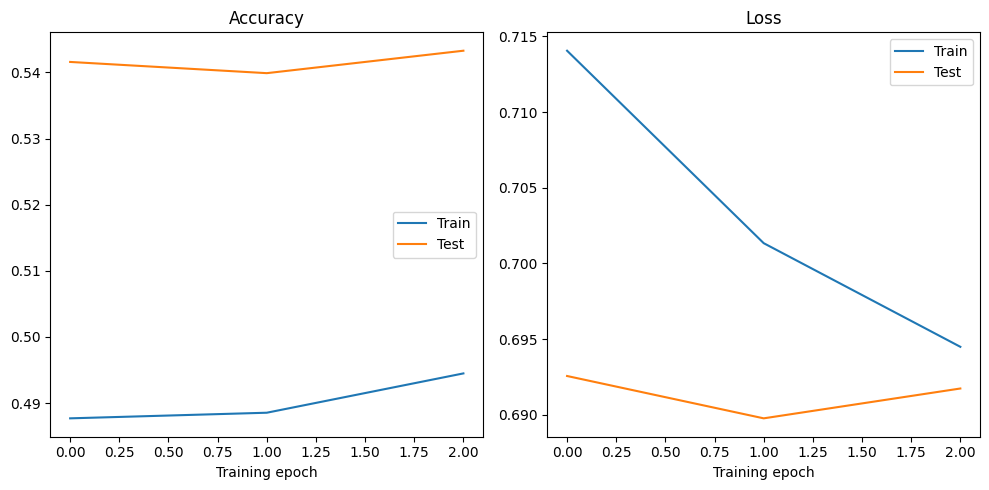

Testing hidden_nodes=10, iteration=3
Test Accuracy: 0.5212224125862122


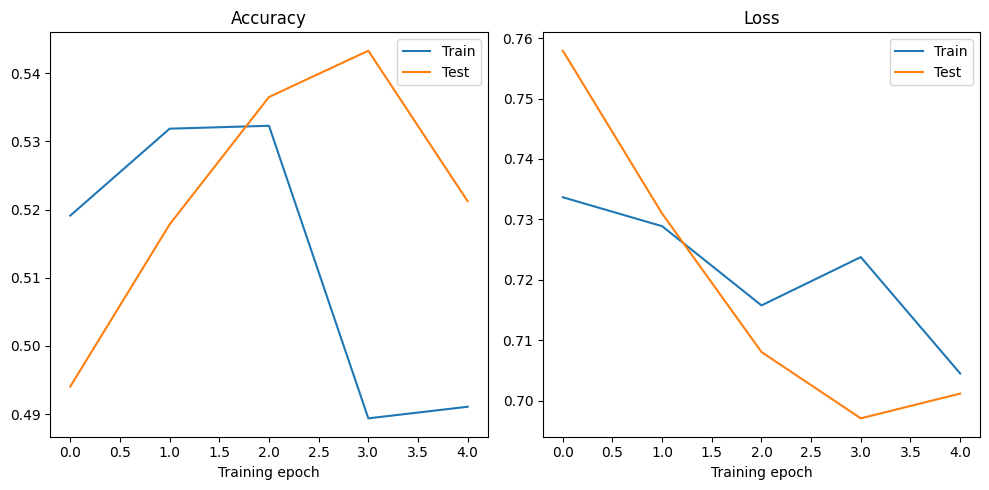

Testing hidden_nodes=30, iteration=1
Test Accuracy: 0.5432937145233154


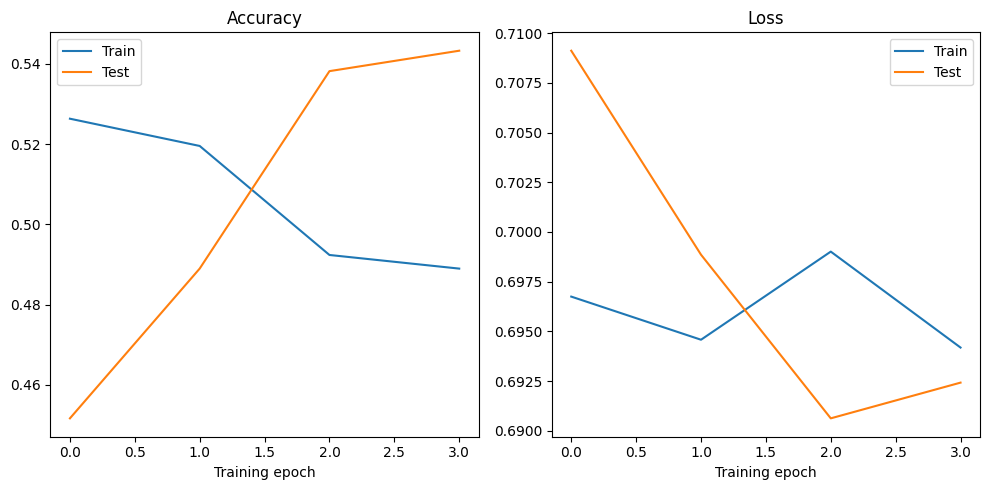

Testing hidden_nodes=30, iteration=2
Test Accuracy: 0.45500847697257996


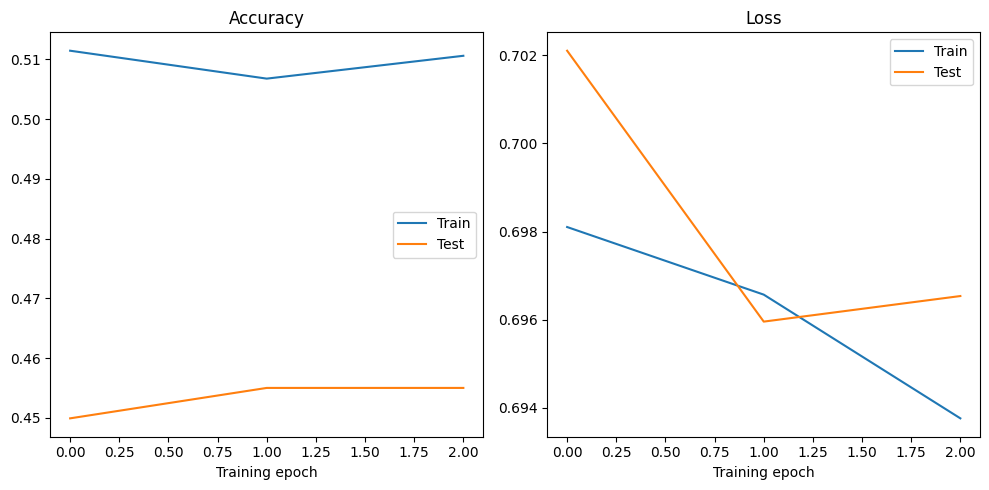

Testing hidden_nodes=30, iteration=3
Test Accuracy: 0.45670628547668457


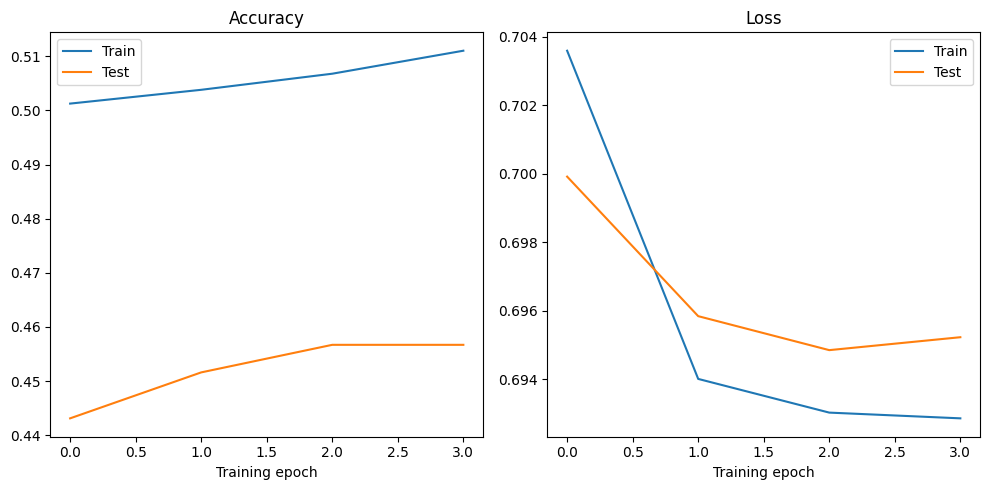


Results:
Hidden Nodes: 3, Accuracies: [0.5415959358215332, 0.5432937145233154, 0.4651952385902405], Average Accuracy: 0.516694962978363
Hidden Nodes: 10, Accuracies: [0.5432937145233154, 0.5432937145233154, 0.5212224125862122], Average Accuracy: 0.5359366138776144
Hidden Nodes: 30, Accuracies: [0.5432937145233154, 0.45500847697257996, 0.45670628547668457], Average Accuracy: 0.48500282565752667


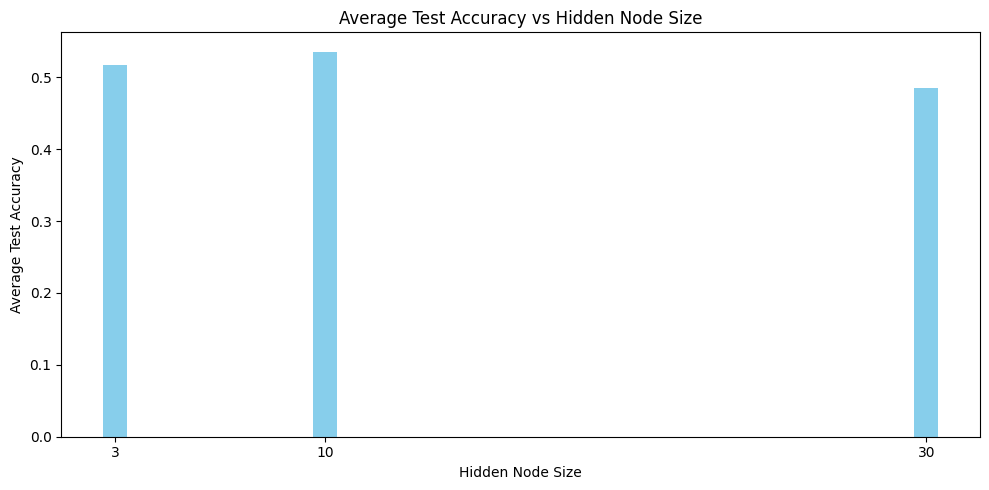

In [139]:
from TIMBRE import TIMBRE
from matplotlib import pyplot as plt
import numpy as np

# Parameters for TIMBRE
hidden_node_sizes = [3, 10, 30]  # Hidden node sizes to test
learn_rate = 0.001
is_categorical = True
iterations = 3  # Number of iterations per hidden node size

# Store results
results = {size: [] for size in hidden_node_sizes}

# Loop over hidden node sizes and iterations
for hidden_nodes in hidden_node_sizes:
    for iteration in range(iterations):
        print(f"Testing hidden_nodes={hidden_nodes}, iteration={iteration + 1}")

        # Call TIMBRE
        model, fitted_model, test_acc = TIMBRE(
            X=X,
            Y=Y,
            inds_test=inds_test,
            inds_train=inds_train,
            hidden_nodes=hidden_nodes,
            learn_rate=learn_rate,
            is_categorical=is_categorical,
            verbosity=0  # Suppress detailed output for cleaner logs
        )

        # Store test accuracy
        results[hidden_nodes].append(test_acc)
        print(f"Test Accuracy: {test_acc}")

        # Plot accuracy and loss from fittedModel
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        # Plot training vs. validation accuracy
        axs[0].plot(fitted_model.history['accuracy'], label='Train')
        axs[0].plot(fitted_model.history['val_accuracy'], label='Test')
        axs[0].set_title('Accuracy')
        axs[0].set_xlabel('Training epoch')
        axs[0].legend()

        # Plot training vs. validation loss
        axs[1].plot(fitted_model.history['loss'], label='Train')
        axs[1].plot(fitted_model.history['val_loss'], label='Test')
        axs[1].set_title('Loss')
        axs[1].set_xlabel('Training epoch')
        axs[1].legend()

        plt.tight_layout()
        plt.show()

# Calculate average accuracy for each hidden node size
average_accuracies = {size: np.mean(accs) for size, accs in results.items()}

# Print results
print("\nResults:")
for size, accs in results.items():
    print(f"Hidden Nodes: {size}, Accuracies: {accs}, Average Accuracy: {average_accuracies[size]}")

# Plot results
fig, ax = plt.subplots(figsize=(10, 5))

hidden_sizes = list(average_accuracies.keys())
average_accs = list(average_accuracies.values())

ax.bar(hidden_sizes, average_accs, color='skyblue')
ax.set_title("Average Test Accuracy vs Hidden Node Size")
ax.set_xlabel("Hidden Node Size")
ax.set_ylabel("Average Test Accuracy")
plt.xticks(hidden_sizes)
plt.tight_layout()
plt.show()
